In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import requests
import config
import numpy as np
from pprint import pprint
import os

## Metro Data

In [2]:
#read data from a txt and convert date column to datetime
data_file = 'data_acquisition/metro_rail/All_Metro.txt'
metro_df=pd.read_csv(data_file, delim_whitespace=True)
metro_df['Date'] = pd.to_datetime(metro_df['Date'],format='%Y%m')
#save to CSV 
path_to_metro = 'data_acquisition/metro_rail/metro.csv'
metro_df.to_csv(path_to_metro)

## Uber Data

In [7]:
import glob
# Write a path to the files and an empty df
path = glob.glob('data_acquisition/uber/raw_data/monthly/*/*.csv')
df = pd.DataFrame()
# Create merged df
x = 0
for filepath in path:
    name = filepath.split('/')
    readfile = pd.read_csv(filepath)
    df_x = pd.DataFrame(readfile)
    df_x['year'] = int(name[-2])
    
    df = df.append(df_x, ignore_index=True)
    x += 1
df.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,year
0,199,168,2,794.67,290.81,753.40,1.38,2016
1,228,462,2,1269.82,398.15,1220.03,1.31,2016
2,189,268,2,1126.76,276.63,1094.08,1.27,2016
3,330,15,2,855.19,350.61,801.30,1.41,2016
4,198,178,2,668.67,229.27,635.92,1.36,2016


In [8]:
# Change date format, count a number of rides
df1 = df[['month', 'year', 'dstid']].groupby(['year', 'month']).count().reset_index()
months = {1:('01',31), 2:('02',28), 3:('03',31), 4:('04',30), 5:('05',31), 6:('06',30),
          7:('07',31), 8:('08',31), 9:('09',30), 10:('10',31), 11:('11',30), 12:('12',31)}
for ind, row in df1.iterrows():
    df1.at[ind, 'mon'] = months[row['month']][0]
    df1.at[ind, 'date'] = ''
    df1.at[ind, 'uber_count'] = months[row['month']][1]
df1['date'] = df1['year'].astype(str) + df1['mon']
df1['uber_count'] = df1['dstid'] * df1['uber_count']
df1 = df1.drop(df1.columns[[0, 1, 2, 3]], axis=1)

In [9]:
# Export to csv
path_to_uber = 'data_acquisition/uber/uber_monthly.csv'
df1.to_csv(path_to_uber, index=False)

## Bus Data

### Code to get bus positions via WMATA API

In [10]:
#request all buses positions
def getBusPositions(api_key):
    headers = {'api_key':api_key}
    '''
    requests all buses positions
    '''
    r = requests.get('https://api.wmata.com/Bus.svc/json/jBusPositions', headers=headers)
    if r.status_code == 200:
        response = r.json()
        return response
    else:
        print(f'getBusPositions: Unable to get the data. Error code: {r.status_code}')
        return False

#collecting bus positions and saving them to the file
def collectBusPositions():

    results = getBusPositions(config.api_key)

    if results:
        bus_positions = pd.DataFrame(results['BusPositions'])
        
        #convert date columns to datetime type
        bus_positions.loc[:, ['DateTime','TripEndTime','TripStartTime']] = \
            bus_positions.loc[:, ['DateTime','TripEndTime','TripStartTime']].apply(pd.to_datetime, errors='coerce')

        # if file does not exist write header 
        path = 'data_acquisition/bus/resources/bus_positions.csv'
        if not os.path.isfile(path):
            bus_positions.to_csv(path,index=False, )
        else: # else it exists so append without writing the header
            bus_positions.to_csv(path,mode = 'a',header=False,index=False)

if __name__ == '__main__':
    collectBusPositions()
    
print('Finished')

Finished


### Code to combine into one multiple CSV files with ridership data

In [11]:
#data from July through June 
def readData():
    #cicle through year's CSV
    result = pd.DataFrame(columns=['Ridership'])
    for year in range(2013,2018):
        #read csv
        path = 'data_acquisition/bus/resources/Ridership_Data_for_FY_' + str(year) + '.csv'
        df = pd.read_csv(path)

        #leave the ridership columns only
        df = df[['Operator','July','August','September', \
                 'October','November','December', \
                 'January','February','March',\
                 'April','May','June']]

        #choose the bus lines to keep
        operators = (df['Operator']=='ART Bus')|(df['Operator']=='DC Circulator')|(df['Operator']=='MTA')|(df['Operator'] == 'Metro Bus') 
        df = df.loc[operators]

        #rename columns
        columns = ['Operator'] + \
                  [x + str(year) for x in df.columns.tolist()[1:7]] + \
                  [x + str(year+1) for x in df.columns.tolist()[7:]]
        df.columns = columns
        df = df.set_index('Operator')

        #setup datetime format
        rdT = df.transpose()
        rdT['date'] = rdT.index
        rdT = pd.melt(rdT, id_vars=['date'])
        rdT = rdT.groupby('date').agg({'value':sum})
        rdT.index = pd.to_datetime(rdT.index).strftime('%Y%m')
        rdT.columns = ['Ridership']
        result = result.append(rdT)
    return result

#collect and combine all the data
combined = readData().sort_index()
combined.index.name = 'Date'
combined.head()
#save to CSV
path_to_bus = 'data_acquisition/bus/resources/bus.csv'
combined.to_csv(path_to_bus)
print('Finished')

Finished


## Taxi Data

In [12]:
path_to_taxi = 'data_acquisition/taxi/raw_data/DC_Taxicab_trip.xlsx'

## Combine files

In [13]:
#read CSVs to DFs
bus_df = pd.read_csv(path_to_bus)
metro_df = pd.read_csv(path_to_metro)
uber_df = pd.read_csv(path_to_uber)
taxi_df = pd.read_excel(path_to_taxi)

In [14]:
bus_df.columns=['Date','Bus']
bus_df['Date'] = pd.to_datetime(bus_df['Date'],format='%Y%m')
bus_df.head()

metro_df = metro_df[['Date', 'ROTP', 'RailReliability', 'MetroAccessOTP',
       'EscalatorAvail', 'ElevatorAvail', 'TotalInjuries', 'Crime',
       'Ridership']]
metro_df.columns = ['Date', 'ROTP', 'RailReliability', 'MetroAccessOTP',
       'EscalatorAvail', 'ElevatorAvail', 'TotalInjuries', 'Crime',
       'Metro']
metro_df['Date'] = pd.to_datetime(metro_df['Date'])
metro_df.head()

metro_ride = metro_df[['Date','Metro']]
metro_ride.head()

taxi_df.columns=['Date','Taxi']
taxi_df['Date'] = pd.to_datetime(taxi_df['Date'],format='%Y%m')
taxi_df.head()

uber_df.columns = ['Date','Uber']
uber_df['Date'] = pd.to_datetime(uber_df['Date'],format='%Y%m')
uber_df.head()

combined_df = pd.merge(bus_df,metro_ride,on='Date',how='outer')
combined_df = pd.merge(combined_df,taxi_df,on='Date',how='outer')
combined_df = pd.merge(combined_df,uber_df,on='Date',how='outer')
combined_df = combined_df.sort_values('Date').set_index('Date')
combined_df.head()

,Bus,Metro,Taxi,Uber
Date,,,,
2011-01-01,NaN,21082553.0,NaN,NaN
2011-02-01,NaN,21228262.0,NaN,NaN
2011-03-01,NaN,26170157.0,NaN,NaN
2011-04-01,NaN,25656797.0,NaN,NaN
2011-05-01,NaN,24342603.0,NaN,NaN


In [15]:
#save combined files for analysis
combined_df.to_csv('results/combined.csv')
metro_df.to_csv('results/metro_kpi.csv')

## Plot preliminary graphs

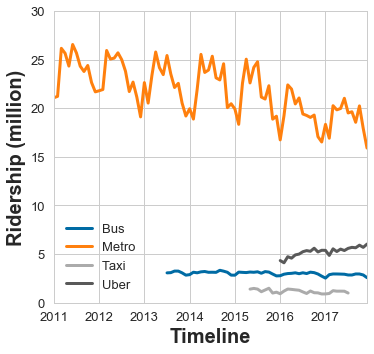

In [132]:
plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(5,5))

combined_df.plot(ax=ax,linewidth=3)

#set y axis scale to million
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Ridership (million)',weight='bold',size='20')
ax.set_xlabel('Timeline',weight='bold',size='20')
ax.set_ylim(0,30*1e6)
ax.set_xlim(492,575)

#plt.title('Ridership in DC Area')

plt.savefig('results/plots/all_ridership_by_month.png',dpi=150,transparent=True,bbox_inches='tight')


plt.show()

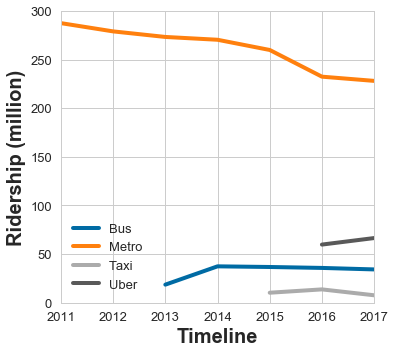

In [133]:
#combine by year
combined_df_by_year = combined_df.groupby(combined_df.index.year).agg(sum).fillna(value=np.nan)
#make sure 0 from groupby won't make to the graph
combined_df_by_year = combined_df_by_year.replace(0,np.nan)
#drop 2018 since it doesn't have all the data yet
combined_df_by_year = combined_df_by_year.drop(2018)
#combined_df_by_year

plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(5,5))

combined_df_by_year.plot(ax=ax,linewidth=4)
ax.set_ylabel('Ridership (million)',weight='bold',size='20')
ax.set_xlabel('Timeline',weight='bold',size='20')
#plt.title('Washington Metropolitan Area Ridership',weight='bold',size='25')

#set y axis scale to million
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylim(0,300*1e6)
ax.set_xlim(2011,2017)

plt.savefig('results/plots/all_ridership_by_year.png',dpi=150,transparent=True,bbox_inches='tight')

plt.show()

In [136]:
metro_df.head()

,Date,ROTP,RailReliability,MetroAccessOTP,EscalatorAvail,ElevatorAvail,TotalInjuries,Crime,Metro
0,2011-01-01,0.879,48241,0.901,0.888,96.30%,2.08,6.39,21082553
1,2011-02-01,0.887,37703,0.890,0.866,96.00%,1.66,4.68,21228262
2,2011-03-01,0.910,50328,0.913,0.869,96.90%,2.16,3.96,26170157
3,2011-04-01,0.909,39302,0.912,0.862,96.40%,2.21,4.72,25656797
4,2011-05-01,0.909,37355,0.922,0.825,97.40%,1.69,7.32,24342603


In [134]:
#look at metro KPIs
metro_kpi = metro_df[['Date','ROTP', 'RailReliability', 'MetroAccessOTP', 'EscalatorAvail',
       'ElevatorAvail', 'TotalInjuries', 'Crime',]]
metro_kpi = metro_kpi.set_index('Date')
metro_kpi.columns

Index(['ROTP', 'RailReliability', 'MetroAccessOTP', 'EscalatorAvail',
       'ElevatorAvail', 'TotalInjuries', 'Crime'],
      dtype='object')

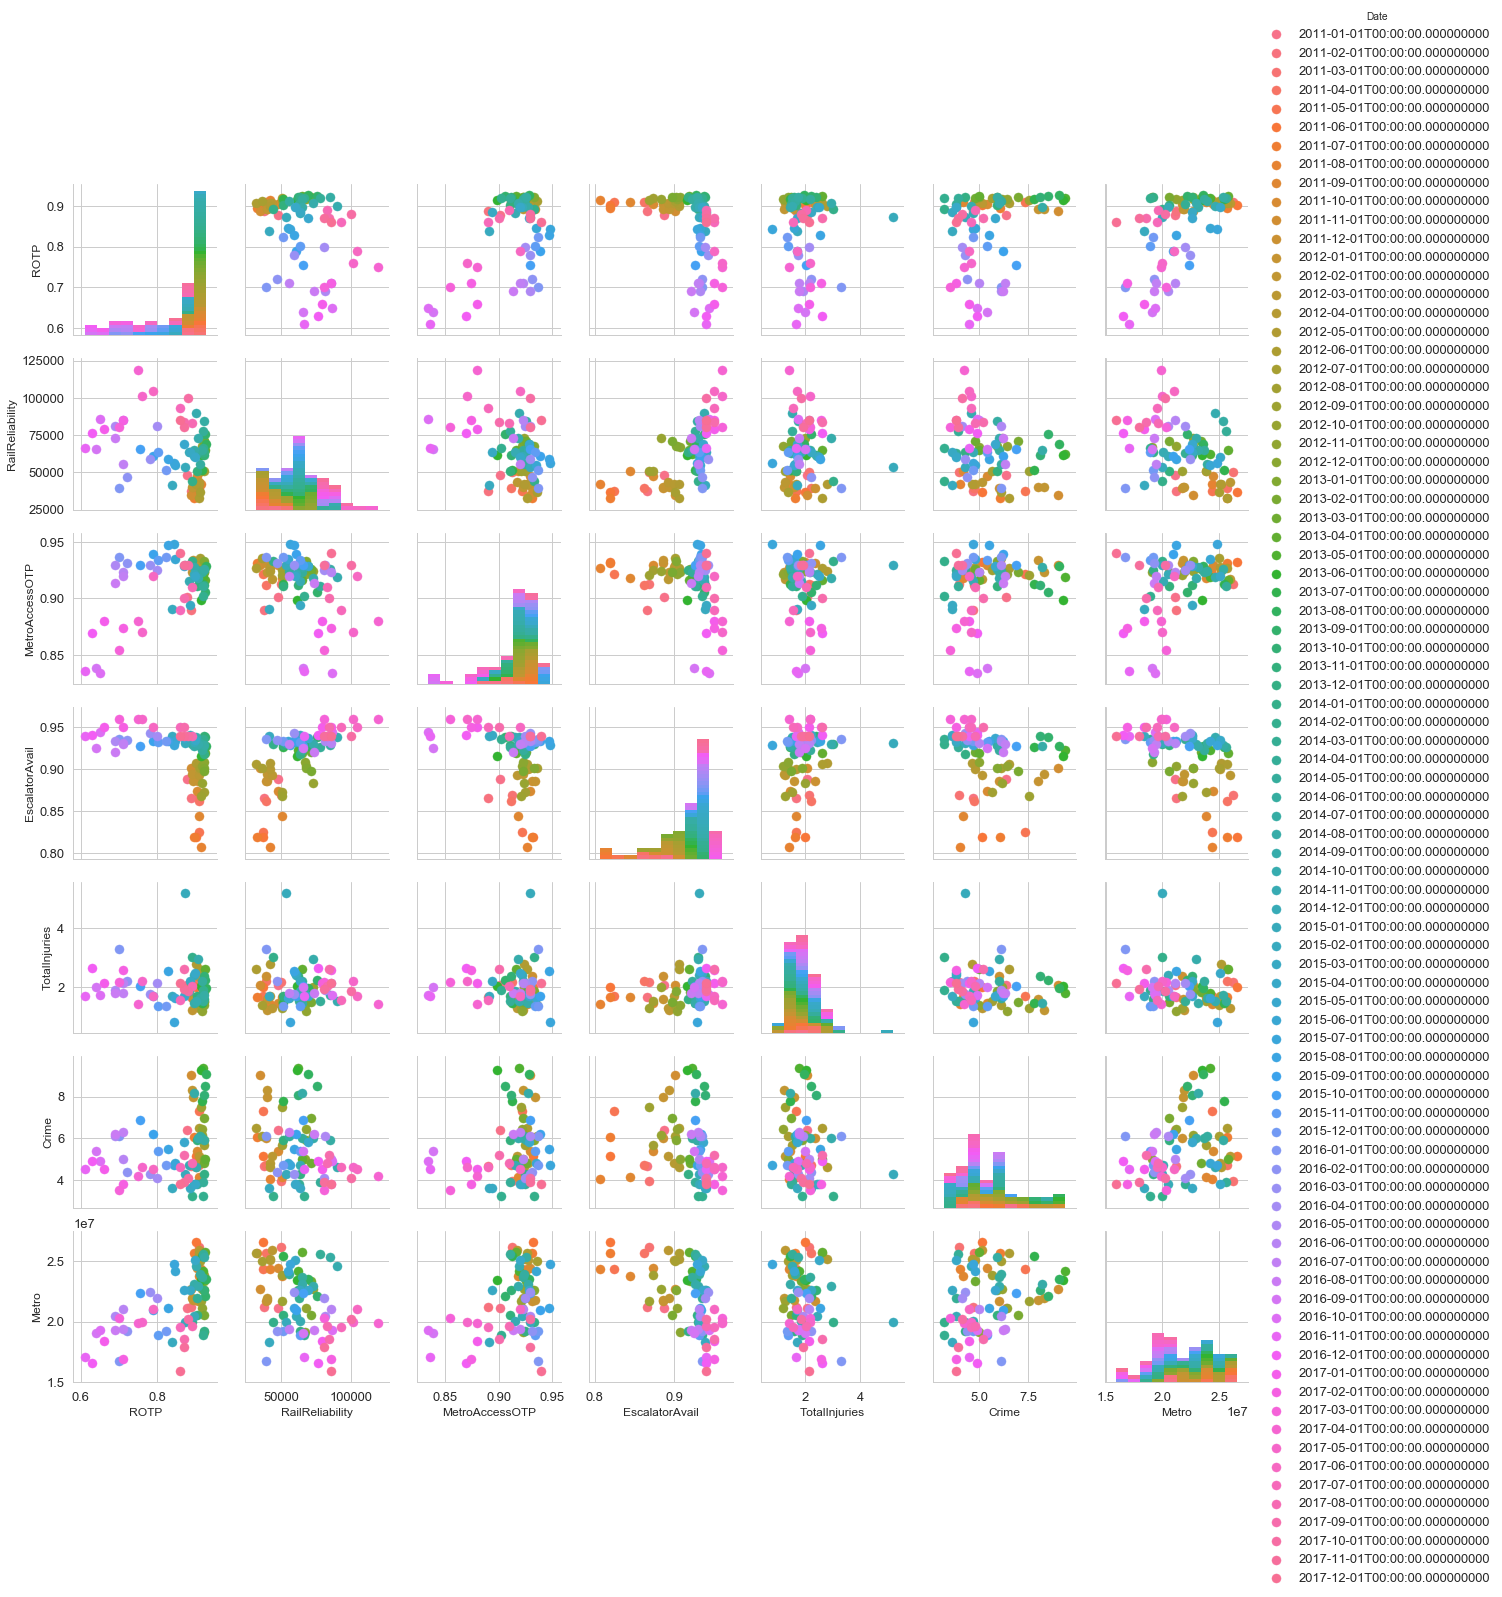

In [152]:
import seaborn as sns

g = sns.PairGrid(metro_df,hue='Date')
#g.map(plt.scatter);

g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#g.map_lower(plt.scatter)
#g.map_upper(sns.kdeplot, cmap="Blues_d")

g.add_legend();

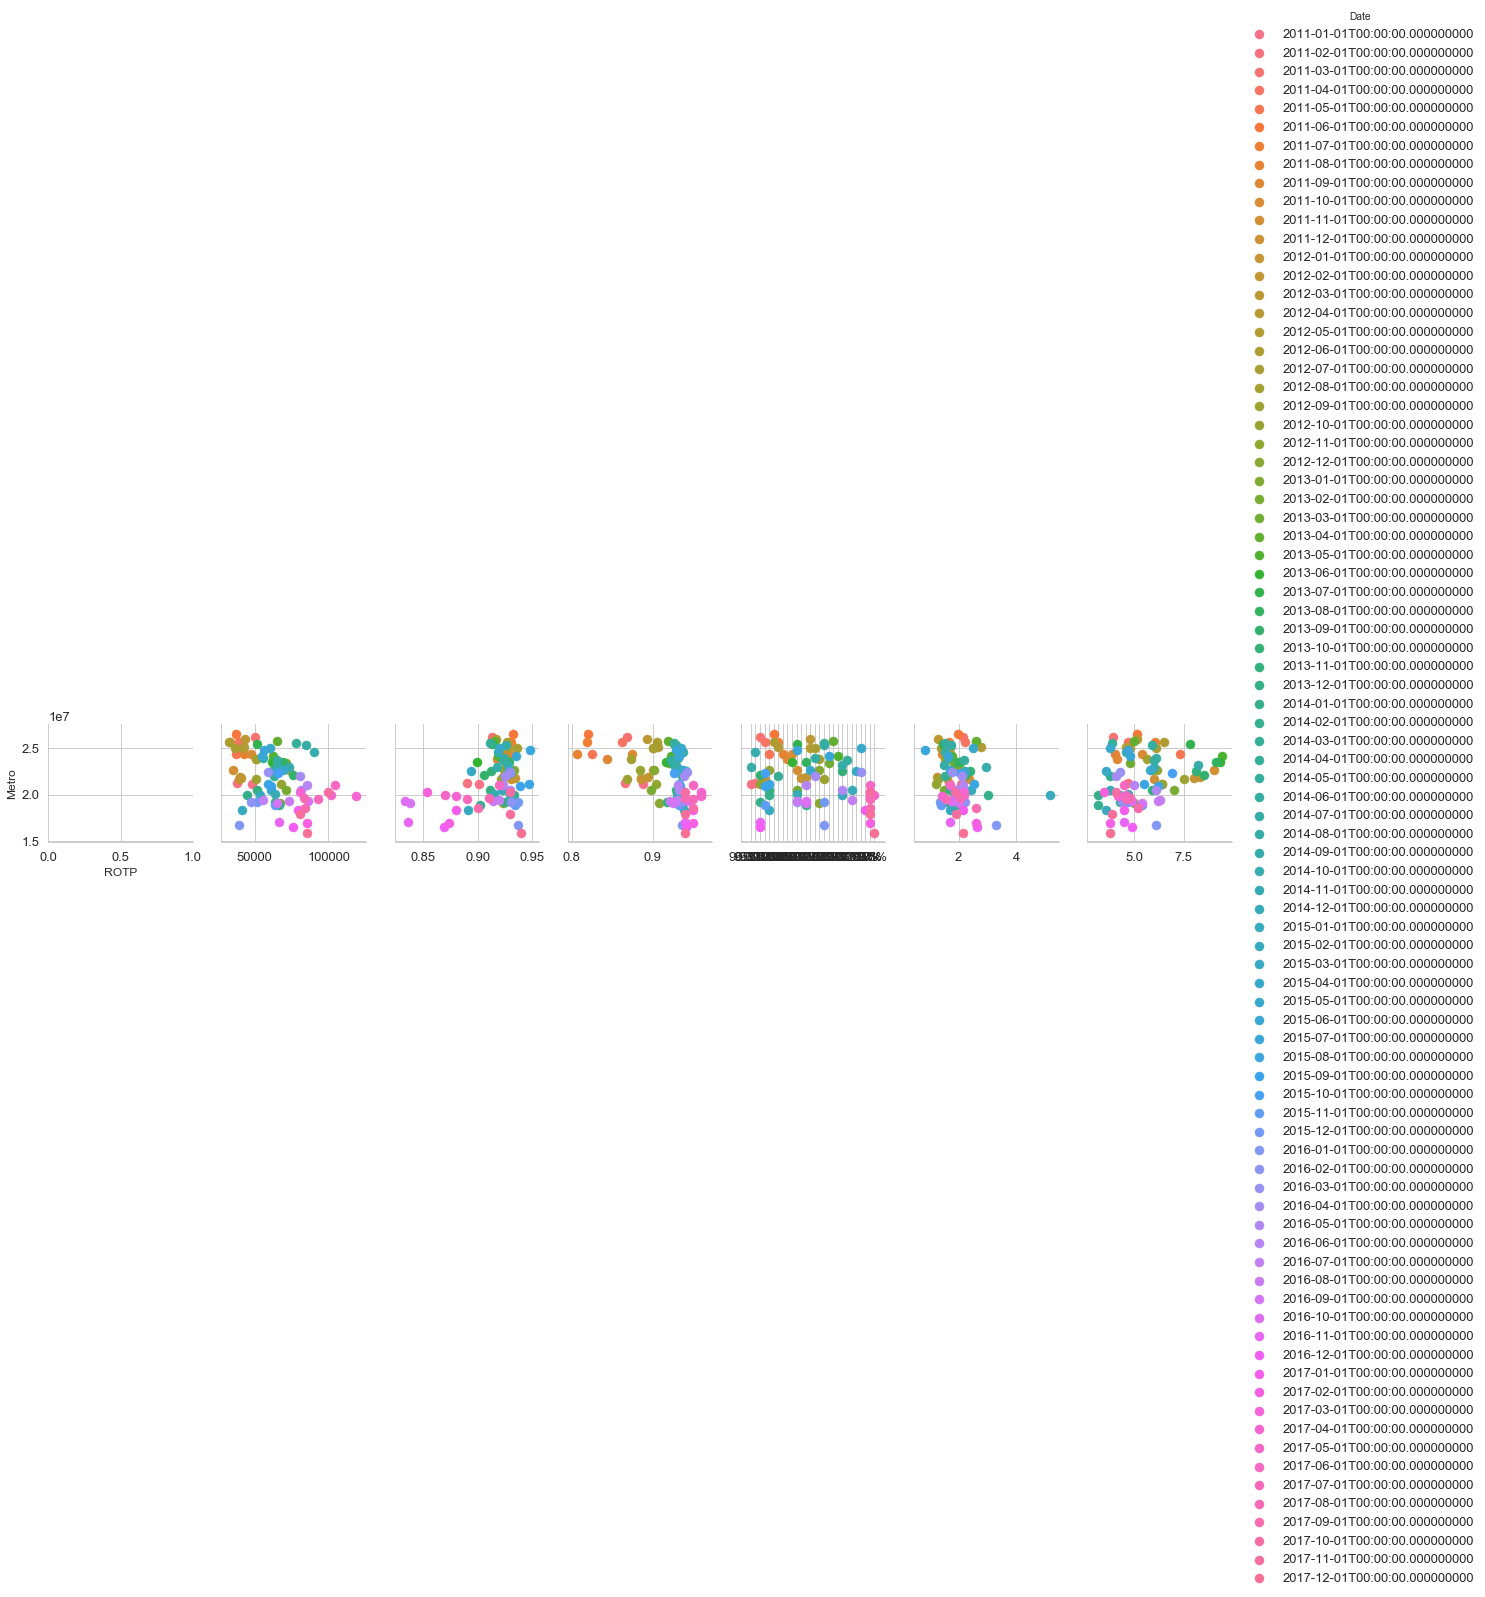

In [159]:
g = sns.PairGrid(metro_df,hue='Date',y_vars=['Metro'], x_vars=['ROTP', 'RailReliability', 'MetroAccessOTP', \
                                                               'EscalatorAvail','ElevatorAvail', 'TotalInjuries', \
                                                               'Crime'])

#g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

g.add_legend()

In [148]:
metro_df.columns

Index(['Date', 'ROTP', 'RailReliability', 'MetroAccessOTP', 'EscalatorAvail',
       'ElevatorAvail', 'TotalInjuries', 'Crime', 'Metro'],
      dtype='object')

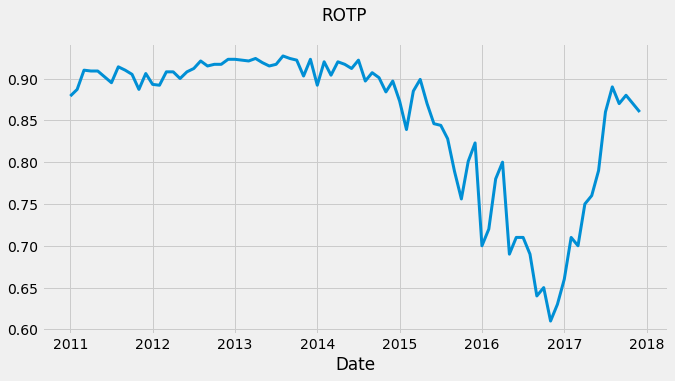

In [36]:
f = plt.figure(figsize=(10,5))
metro_kpi['ROTP'].plot(linewidth=3)
plt.suptitle('ROTP')
plt.show()

In [140]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [180]:
metro_ride.head(2)

,Ridership
Date,
2011-01-01,21082553
2011-02-01,21228262


## Code 1
 rank the year by average
 mean and standard deviation for each months ridership for metro
 run T-test

In [173]:
import calendar
months = [name[:3] for name in calendar.month_name[1:]]

In [252]:
metro_ride = metro_ride.set_index('Date')

mr_by_year = pd.pivot_table(metro_ride, columns=metro_ride.index.month, index=metro_ride.index.year,
                    values='Ridership', aggfunc='sum')
mr_by_year.columns = months
mr_by_year.to_csv('results/table1.csv')
mr_by_year

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Date,,,,,,,,,,,,
2011,21082553,21228262,26170157,25656797,24342603,26563303,25695119,24335209,23787505,24407944,22654619,21691785
2012,21803627,21932092,25948220,25066331,25161639,25709701,25001942,23813095,21722649,22697072,21156527,19116398
2013,22644106,20535443,23377941,25793255,24177214,23464852,25430329,23533749,22138747,22568599,20535975,19205871
2014,19954729,18890899,21971882,25549742,23686634,23936655,25357158,23132836,22917150,24582682,20065907,20468341
2015,19924742,18348425,22574898,25054379,22609113,24206396,24786276,21155750,20952910,22321780,18881833,19188299
2016,16748182,19236884,22407991,21979083,20448297,21065926,19414717,19265960,19060999,19305767,17079887,16532625
2017,18349147,16922920,20269488,19842700,19978369,21030458,19522119,19645882,18560071,20248022,17932152,15908483


In [262]:
stat_month = pd.DataFrame()
stat_month = stat_month.append(mr_by_year.sum(),ignore_index=True)
stat_month = stat_month.append(mr_by_year.mean(),ignore_index=True)
stat_df.index = ['Total Passengers','Monthly Average Passengers']
stat_month

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1.689423e+08,1.548825e+08,1.321118e+08,1.370949e+08,1.405071e+08,1.652077e+08,1.659773e+08,1.627206e+08,1.604039e+08,1.383069e+08,1.561319e+08,1.491400e+08
1,2.413461e+07,2.212607e+07,1.887311e+07,1.958499e+07,2.007244e+07,2.360109e+07,2.371104e+07,2.324580e+07,2.291484e+07,1.975813e+07,2.230455e+07,2.130572e+07


In [188]:
mr_by_month = pd.pivot_table(metro_ride, index=metro_ride.index.month, columns=metro_ride.index.year,
                    values='Ridership', aggfunc='sum')
mr_by_month.index = months
mr_by_month.to_csv('ridership_by_month_year.csv')
mr_by_month.head(3)

Date,2011,2012,2013,2014,2015,2016,2017
Jan,21082553,21803627,22644106,19954729,19924742,16748182,18349147
Feb,21228262,21932092,20535443,18890899,18348425,19236884,16922920
Mar,26170157,25948220,23377941,21971882,22574898,22407991,20269488


In [220]:
stat_df = pd.DataFrame()
stat_df = stat_df.append(mr_by_month.sum(),ignore_index=True)
stat_df = stat_df.append(mr_by_month.mean(),ignore_index=True)
stat_df.index = ['Total Passengers','Monthly Average Passengers']
stat_df.to_csv('results/table2.csv')
stat_df

,2011,2012,2013,2014,2015,2016,2017
Total Passengers,287615856.0,2.791293e+08,2.734061e+08,2.705146e+08,2.600048e+08,2.325463e+08,2.282098e+08
Monthly Average Passengers,23967988.0,2.326077e+07,2.278384e+07,2.254288e+07,2.166707e+07,1.937886e+07,1.901748e+07


In [270]:
table3 = mr_by_year.copy()

for year in range(2011,2018):
    for month in months:
        table3.loc[year,month] = table3.loc[year,month]/stat_df.loc['Monthly Average Passengers',:][year]*100
table3 = table3.round(2)
table3 = table3.append(stat_month)
table3.index = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 'Total Passengers','Monthly Average Passengers']
table3.columns = months
table3.to_csv('results/table3.csv')
table3

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2011,1.070500e+02,1.015300e+02,9.050000e+01,8.857000e+01,8.796000e+01,1.072100e+02,1.108300e+02,1.091900e+02,1.015600e+02,9.452000e+01,1.018400e+02,9.925000e+01
2012,1.077600e+02,1.023700e+02,8.218000e+01,9.429000e+01,9.374000e+01,1.074900e+02,1.105300e+02,1.115500e+02,1.081700e+02,9.095000e+01,9.758000e+01,9.339000e+01
2013,1.132100e+02,1.032900e+02,8.430000e+01,9.013000e+01,9.939000e+01,1.116200e+02,1.029900e+02,1.026100e+02,1.061200e+02,9.013000e+01,9.906000e+01,9.717000e+01
2014,1.133400e+02,1.026200e+02,9.080000e+01,8.380000e+01,8.852000e+01,1.124800e+02,1.061800e+02,9.747000e+01,1.050700e+02,8.901000e+01,1.090500e+02,1.016600e+02
2015,1.156300e+02,9.764000e+01,8.856000e+01,8.468000e+01,9.196000e+01,1.144000e+02,1.117200e+02,1.041900e+02,1.043500e+02,8.715000e+01,1.030200e+02,9.670000e+01
2016,1.134200e+02,9.942000e+01,8.531000e+01,9.927000e+01,8.643000e+01,1.001900e+02,1.087100e+02,1.156300e+02,1.055200e+02,8.814000e+01,9.962000e+01,9.836000e+01
2017,1.043400e+02,1.033000e+02,8.365000e+01,8.899000e+01,9.649000e+01,1.026500e+02,1.105800e+02,1.065800e+02,1.050500e+02,9.429000e+01,1.064700e+02,9.759000e+01
Total Passengers,1.689423e+08,1.548825e+08,1.321118e+08,1.370949e+08,1.405071e+08,1.652077e+08,1.659773e+08,1.627206e+08,1.604039e+08,1.383069e+08,1.561319e+08,1.491400e+08
Monthly Average Passengers,2.413461e+07,2.212607e+07,1.887311e+07,1.958499e+07,2.007244e+07,2.360109e+07,2.371104e+07,2.324580e+07,2.291484e+07,1.975813e+07,2.230455e+07,2.130572e+07


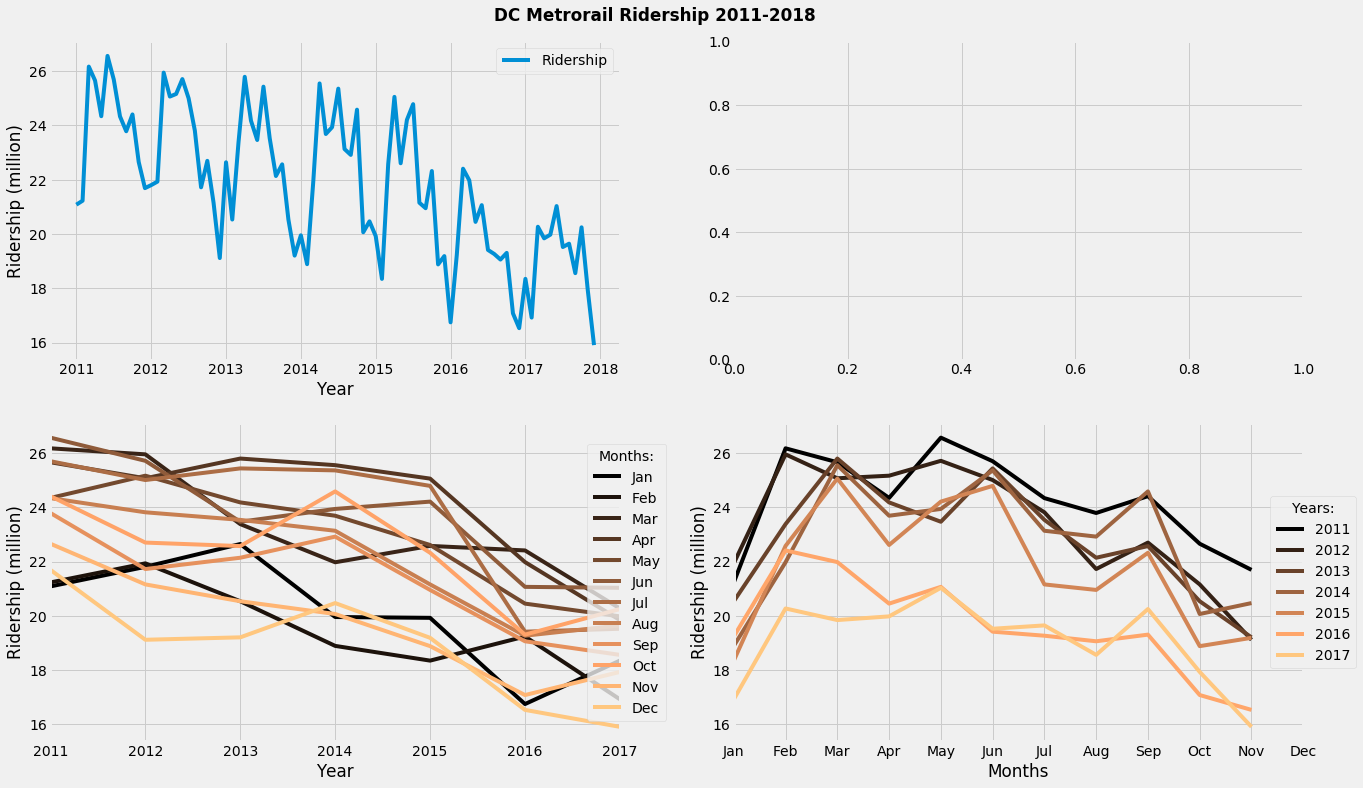

In [272]:
import matplotlib.ticker as ticker
#plot 1. metro ridership by month
f, (ax) = plt.subplots(2,2,figsize=(20,12))
metro_ride.plot(ax=ax[0,0])
mr_by_year.plot(ax=ax[1,0],colormap='copper')
mr_by_month.plot(ax=ax[1,1],colormap='copper')
#plt.plot(xnew,ridership_smooth)

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax[1,0].yaxis.set_major_formatter(ticks_y)
ax[0,0].yaxis.set_major_formatter(ticks_y)
ax[1,1].yaxis.set_major_formatter(ticks_y)


plt.suptitle('DC Metrorail Ridership 2011-2018',y=.92,weight='bold')
ax[0,0].set_ylabel('Ridership (million)')
ax[1,0].set_ylabel('Ridership (million)')
ax[1,1].set_ylabel('Ridership (million)')

ax[0,0].set_xlabel('Year')
ax[1,0].set_xlabel('Year')
ax[1,1].set_xlabel('Months')
ax[1,1].set_xlim(1,11)
ax[1,0].set_xlim(2011,2017)

tick_locations = [m for m in range(1,13)]
plt.xticks(tick_locations, months)

ax[1,0].legend(loc='center left', bbox_to_anchor=(.93, 0.5),title='Months:',labels=months)
ax[1,1].legend(loc='center left', bbox_to_anchor=(.93, 0.5),title='Years:',labels=[y for y in range(2011,2018)])

plt.savefig('results/plot.png')
plt.show()

In [ ]:
# code 2
# build linear regression metro Ridership vs each KPI
# coefficients Slope, Y intercept and R
# use exogenous variable to code Safetrip